# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Import Cleaned Data

In [ ]:
data_clean = pd.read_csv('data_clean.csv')
data_clean.sample(frac=1)
Characters_per_rank = (data_clean.Characters.value_counts()).index 
#data_clean = data_clean[:20000]
data_clean.shape

(49739, 6)

In [ ]:
# Select and Label Dataset for Modeling

In [ ]:
threshold = 7
names={0:'MONICA', 1:'JOEY', 2:'CHANDLER', 3:'PHOEBE',4:'RACHEL',5:'ROSS',6:'Others'}
names_rev={'MONICA':0, 'JOEY':1, 'CHANDLER':2, 'PHOEBE':3,'RACHEL':4,'ROSS':5,'Others':6}

data_thres = data_clean
data_thres['Characters']= data_clean['Characters'].apply(lambda x: 'Others' if (x not in names.values()) else x)

data_thres['target'] = data_thres.apply(lambda x: names_rev.get(x.Characters),axis=1)
data_thres[:10]

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3
5,5,101,Monica Gets A Roommate,MONICA,okay everybody relax even date two people go d...,1,0
6,6,101,Monica Gets A Roommate,CHANDLER,sound like date,1,2
7,7,101,Monica Gets A Roommate,CHANDLER,alright i'm back high school i'm stand middle ...,1,2
8,8,101,Monica Gets A Roommate,Others,oh yeah dream,1,6
9,9,101,Monica Gets A Roommate,CHANDLER,look realize there's phone,1,2


In [ ]:
# split the clean text in the rows  into list of words
tokenized_data = data_thres["Lines"].apply(lambda text: re.split(' ',text))

target_thres = data_thres['target'] 
my_tags = data_thres['Characters'].unique()
my_tags

array(['MONICA', 'JOEY', 'CHANDLER', 'PHOEBE', 'Others', 'ROSS', 'RACHEL'],
      dtype=object)

In [ ]:
data_thres.head()

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3


# Feature Engineering using Count Vectrizer

## Count Vectorizer

In [ ]:
# Create a BoW with Count Vectorizer 


def count_vectorizer(data):
    vectorizer = CountVectorizer(ngram_range = (1,2), min_df=10)
    # call `fit` to build the vocabulary
    vectorizer.fit(data)

    # call `transform` to convert text to a bag of words
    count_vectorizer_result  = vectorizer.transform(data)

    #convert to a numpy array to visualize as dataframe
    count_vectorizer_result = count_vectorizer_result.toarray()
    count_vectorizer_features = pd.DataFrame(count_vectorizer_result , columns = vectorizer.get_feature_names())
    count_vectorizer_features.index = data.index
    return count_vectorizer_features

count_vectorizer_df = count_vectorizer(data_thres['Lines'])
count_vectorizer_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(49739, 4406)

## Train-Test Split

In [ ]:
Count_vectorizer_x_train, Count_vectorizer_x_test, Count_vectorizer_y_train, Count_vectorizer_y_test = train_test_split(count_vectorizer_df,target_thres,test_size = 0.2,random_state =42)

Count_vectorizer_x_train.shape

(39791, 4406)

## Plot Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, figsize=(15, 15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## Saving Model to Disk

In [ ]:
import pickle
def save_model(model,filename):
  pickle.dump(model, open(filename+".sav", 'wb'))

# Logistic Regression

In [ ]:
# Cross-validation
def word_embedding_performance_eval(clf,X,Y):
    Eval_score =  cross_val_score(clf,X,Y, cv=5)
    return  Eval_score.mean() 
    
model =  LogisticRegression(max_iter = 1e6)
LR_Count_Vector = word_embedding_performance_eval(model,Count_vectorizer_x_train,Count_vectorizer_y_train)
LR_Count_Vector

0.2503079981310348

## Accuracy for Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score
model_lr =  LogisticRegression(max_iter = 1e6)
model_lr.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model_lr,"cv-lr-frnds")
y_pred = model_lr.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)


0.24708484117410534

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Count_vectorizer_y_test, y_pred)

array([[307, 184, 151, 106, 312, 184, 106],
       [164, 455, 174, 103, 218, 192,  94],
       [190, 227, 326, 102, 263, 205, 116],
       [166, 162, 144, 239, 300, 176, 100],
       [201, 215, 158, 137, 569, 226, 115],
       [169, 247, 186, 118, 285, 379, 134],
       [181, 219, 152, 100, 279, 213, 199]])

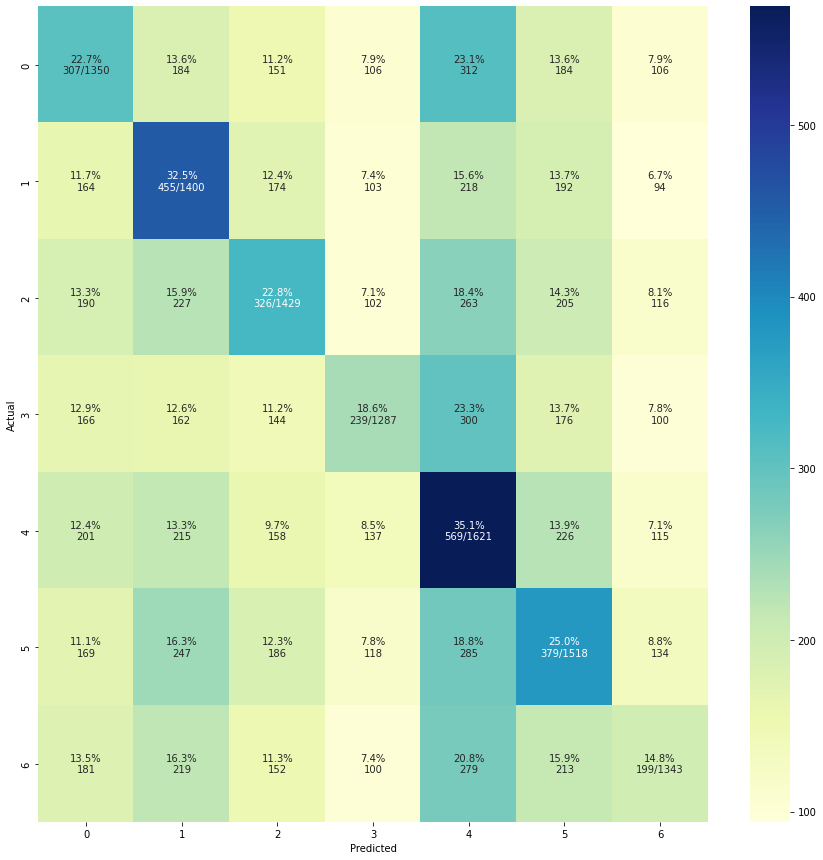

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)

# ROC LR

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_lr.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.6326684978453182

## Optimize Logistic Regression for Best BOW/ Word Embedding Approach

In [ ]:
# Unable to run this due to computational issues
model =  LogisticRegression(max_iter = 1e6)
params_log = { "C": [1e-2,1, 10, 1e2,1e6]}

grid_log = GridSearchCV(model, param_grid=params_log, cv=5)
grid_log.fit(tfidf_df,target_thres)

print(grid_log.best_score_)
print(grid_log.best_params_)

## Naive Bayes with Count Vectorization 

In [ ]:
model = MultinomialNB()
print(cross_val_score(model,Count_vectorizer_x_train,Count_vectorizer_y_train, cv=5).mean())

0.25076046467222174


In [ ]:
# GridSearch with Naive Bayes
def gridsearchNB(clf, X, y):

    #the grid of parameters to search over
    alphas = [0.001,0.01,.1, 1, 5, 10, 50]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    maxscore=-np.inf
    for alpha in alphas:        
        clf = MultinomialNB(alpha=alpha)
        cvscore = max(cross_val_score(clf, X,y,cv = 5))
        if cvscore > maxscore:
                maxscore = cvscore 
                best_alpha = alpha
    return  best_alpha, maxscore

print("Best Case with Count Vectorizer: ", gridsearchNB(model,count_vectorizer_df, target_thres))

## Accuracy for NB

In [ ]:
from sklearn.metrics import accuracy_score
model_nb = MultinomialNB(alpha=5)
model_nb.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model_nb,"cv-nb-frnds")
y_pred = model_nb.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)

0.252010454362686

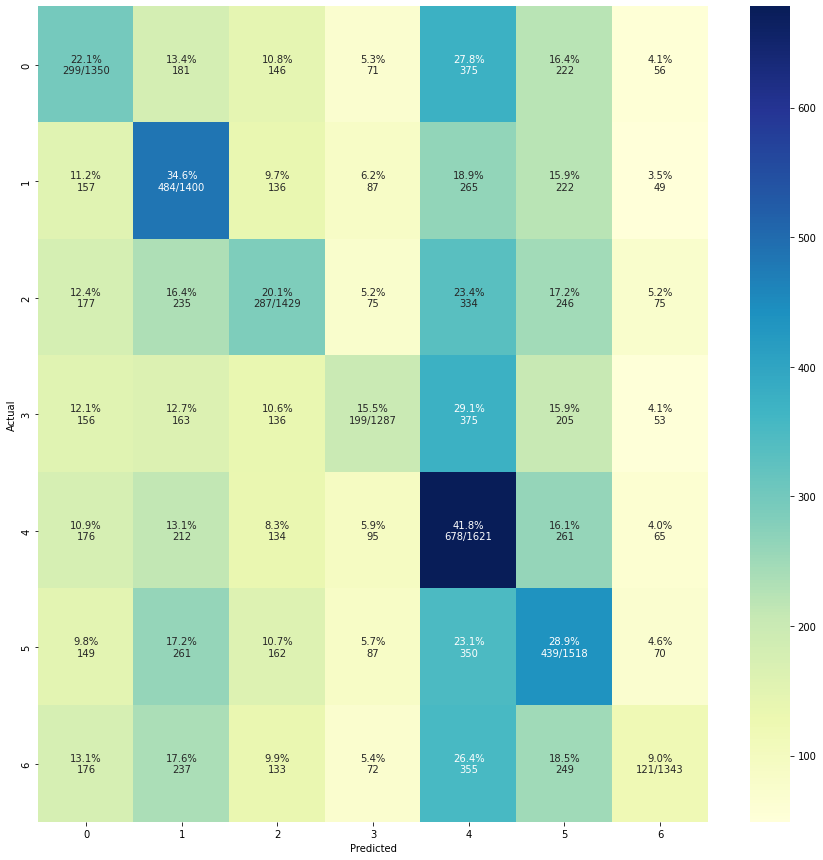

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)

# ROC NB

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_nb.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.6394874525049542

## Support Vector Machine: 

In [ ]:
model_svc =SVC()
print('Accuracy of Support Vector Machine without Gridsearch:', cross_val_score(model_svc,Count_vectorizer_x_train,Count_vectorizer_y_train, cv=5).mean())

Accuracy of Support Vector Machine without Gridsearch: 0.24065764158679404


In [ ]:
from sklearn.metrics import accuracy_score
model_svc = SVC(probability=True)
model_svc.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
save_model(model_svc,"countvec-svc-frnds")
y_pred = model_svc.predict(Count_vectorizer_x_test)
accuracy_score(Count_vectorizer_y_test, y_pred)

0.24587856855649376

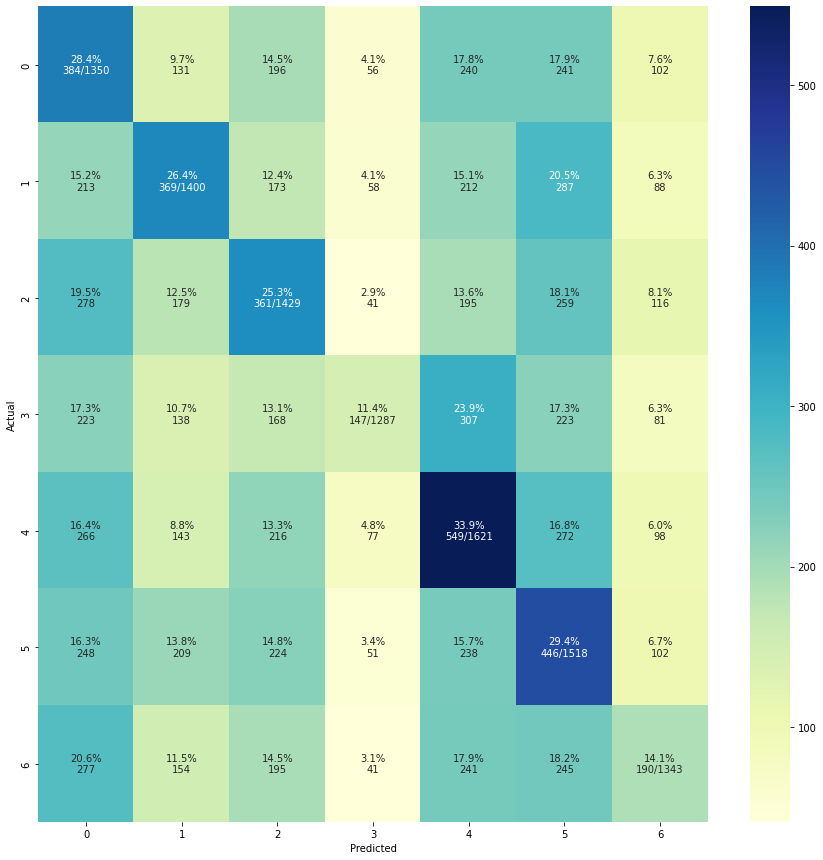

In [ ]:
plot_cm(Count_vectorizer_y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_svc.predict_proba(Count_vectorizer_x_test)
roc_auc_score(Count_vectorizer_y_test, y_prob, multi_class="ovr",average="macro")

0.6250474957972728

In [ ]:
# Unable to run this due to computational issues
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
#kernels =  ['rbf','linear']
params_svc = {'C': Cs, 'gamma' : gammas}
grid_svc = GridSearchCV(SVC(), param_grid = params_svc, cv=5)
grid_svc.fit(Count_vectorizer_x_train,Count_vectorizer_y_train)
print('Optimized Modeling Paramters for Support vector Machine', grid_svm.best_params_)
print('Accuracy of Support Vector Machine with Gridsearch:', grid_svm.best_score_)

In [ ]:
!zip -r /content/svm.zip /content/countvec-svc-frnds.sav

  adding: content/countvec-svc-frnds.sav (deflated 100%)
